(high-level-interface)=
# High Level

You can use `cotengra` as a drop-in replacement for `numpy.einsum` or
`opt_einsum.contract`,
and benefit from the improved optimization, contraction routines and features such as slicing, with the following high level interface functions.

::::{grid} 2
:::{grid-item-card}
Traditional einsum style where the contraction is specified as a compact and more human-readable ``equation`` string:
  - [`cotengra.einsum`](cotengra.einsum)
  - [`cotengra.einsum_tree`](cotengra.einsum_tree)
  - [`cotengra.einsum_expression`](cotengra.einsum_expression)
:::
:::{grid-item-card}
Programmatic style, where the indices can be specified as sequences of arbitrary hashable objects:
  - [`cotengra.array_contract`](cotengra.array_contract)
  - [`cotengra.array_contract_tree`](cotengra.array_contract_tree)
  - [`cotengra.array_contract_expression`](cotengra.array_contract_expression)
:::
::::

The following are equivalent ways to perform a matrix multiplication and transpose of ``x`` and ``y``:

```python
import cotengra as ctg

# einsum style
z = ctg.einsum("ab,bc->ca", x, y)

# programmatic style
z = ctg.array_contract(
  arrays=(x, y),
  inputs=[(0, 1), (1, 2)],
  output=(2, 0),
)
```


The `{_tree}` functions return a [`ContractionTree`](cotengra.ContractionTree) object
which can be used to inspect the order and various properties such as contraction
cost and width. The `{_expression}` functions return a function that performs the
contraction, which can be called with any matching input arrays.
All of these functions take an ``optimize`` kwarg which specifies the
contraction strategy. It can be one of the following:

- ``str`` : a preset such as ``'auto'``, ``'auto-hq'``, ``'greedy'`` or ``'optimal'``
- ``PathOptimizer`` : a custom optimizer from ``cotengra`` or ``opt_einsum``
- ``ContractionTree`` : a contraction tree generated previously
- ``Sequence[tuple[int]]`` : an explicit path of *'linear recycled ids'*, specified manually or generated previously
- ``Sequence[str]`` : an explicit path supplied as an *edge ordering*

If the method provides sliced indices then the contraction will utilize these to reduce the memory. The default is the `cotengra` preset ``'auto'``. If you explicitly want to use an `opt_einsum` preset then you can supply ``optimize='opt_einsum:auto'`` for example.

See the docstring of [`array_contract_expression`](cotengra.array_contract_expression)
for other options.

## `einsum` interfaces:


Here the contraction is specified using the string equation form of
[`numpy.einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)
and other `einsum` implementations. For example:

- ``"ab,bc->ac"`` matrix multiplication
- ``"Xab,Xbc->Xac"`` batch matrix multiplication
- ``"ab,ab->ab"`` hadamard (elementwise) product

```{hint}
`cotengra` supports all types of explicit equation (such as repeated and hyper/batch indices appearing any number of times).
The `einsum` versions also support automatically expanded dimensions using ellipsis ``...``.
```

If the right hand side is not specified then the output indices are computed as every index that appears *once* on the left hand side inputs, in sorted order. For example ``'ba'`` is completed as a transposition: ``'ba->ab'``.

Lets generate a more non-trivial example:

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg

# generate the 'inputs and output' format contraction
inputs, output, shapes, size_dict = ctg.utils.lattice_equation([4, 5])

# generate the 'eq' format
eq = ctg.utils.inputs_output_to_eq(inputs, output)
print(eq)

# make example arrays
arrays = ctg.utils.make_arrays_from_inputs(inputs, size_dict, seed=42)

ab,cbd,edf,gfh,ih,ajk,clkm,enmo,gpoq,irq,jst,lutv,nwvx,pyxz,rAz,sB,uBC,wCD,yDE,AE->


And perform the contraction:

In [2]:
ctg.einsum(eq, *arrays)

array(776.48544934)

If we wanted to inspect the contraction before we perform it we could build the contraction tree first. Here we supply just the shapes of the arrays:

In [3]:
tree = ctg.einsum_tree(eq, *shapes)

# some typical quantities of interest:
tree.contract_stats()

{'flops': 964, 'write': 293, 'size': 32}

The contraction tree has many methods to inspect and manipulate the contraction.

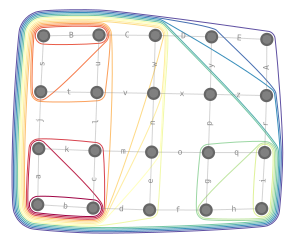

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [4]:
tree.plot_rubberband()

Sometimes it is useful to generate the function that will perform the contraction for any given inputs. This can be done with the [`einsum_expression`](cotengra.einsum_expression) function:

In [5]:
expr = ctg.einsum_expression(eq, *shapes)
expr(*arrays)

array(776.48544934)

In [6]:
arrays = ctg.utils.make_arrays_from_inputs(inputs, size_dict, seed=43)
expr(*arrays)

array(2252.66569969)

```{note}
[`einsum`](cotengra.einsum) itself caches the expressions it uses by default for presets, so at least in terms of performance savings this is often not necessary.
```

## `array_contract` interfaces

The einsum format is less convenient for dynamically generated contractions.
The alternate interface `cotengra` provides are the [`array_contract`](cotengra.array_contract) functions. These specify a contraction with the following three arguments:

    - `inputs : Sequence[Sequence[Hashable]]`, the indices of each input
    - `output : Sequence[Hashable]`, the output indices
    - `size_dict : Mapping[Hashable, int]`, the size of each index

The indices are mapped ('canonicalized') into single letters in the order they appear on the `inputs`, allowing matching geometries to be cached.

If `output` is not specified it is calculated as the indices that appear *once* in `inputs`, in the order they appear in `inputs`. Note this is slightly different to `einsum` which sorts the output indices, since we can only require the indices to be hashable.

```{note}
You can also supply `shapes` to [`array_contract_tree`](cotengra.array_contract_tree) and [`array_contract_expression`](cotengra.array_contract_expression) rather than build ``size_dict`` manually.
```

As an example, we'll directly contract the arrays from a tensor network generated with [`quimb`](https://quimb.readthedocs.io):

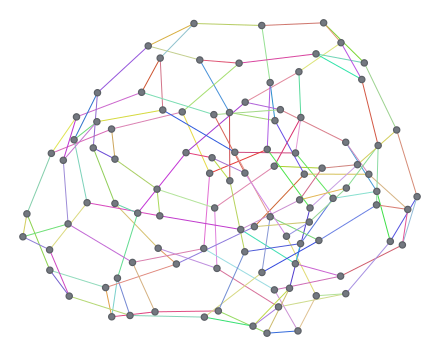

TensorNetworkGen(tensors=100, indices=150)

In [7]:
import quimb.tensor as qtn

tn = qtn.TN_rand_reg(100, 3, D=2, seed=42)
tn.draw(edge_color=True)
tn

Although `quimb` can automatically generate the einsum equation in this case,
it might be generally annoying to construct the string. Instead we can directly
use the tensor networks index names:

In [8]:
arrays = []
inputs = []
for t in tn:
    arrays.append(t.data)
    inputs.append(t.inds)

In this case they are randomly generated unique indentifiers, but they could
be anything hashable, as long as they match the shapes of the arrays and encode the geometry of the contraction.

In [9]:
inputs[:5]

[('_67af2fAAAAC', '_67af2fAAAAB', '_67af2fAAAAA'),
 ('_67af2fAAAAF', '_67af2fAAAAE', '_67af2fAAAAD'),
 ('_67af2fAAAAI', '_67af2fAAAAH', '_67af2fAAAAG'),
 ('_67af2fAAAAL', '_67af2fAAAAK', '_67af2fAAAAJ'),
 ('_67af2fAAAAN', '_67af2fAAAAM', '_67af2fAAAAB')]

Perform the contraction, using the higher quality auto preset:

In [10]:
%%time
ctg.array_contract(arrays, inputs, optimize="auto-hq")

CPU times: user 356 ms, sys: 585 µs, total: 356 ms
Wall time: 322 ms


array(-1.78478002e+15)

Because the contraction expression is cached if we perform the contraction
again with the same preset it will be faster:

In [11]:
%%time
ctg.array_contract(arrays, inputs, optimize="auto-hq")

CPU times: user 157 ms, sys: 4.63 ms, total: 162 ms
Wall time: 33.1 ms


array(-1.78478002e+15)

If you want to relate the internal contraction 'symbols' (single unicode
letters) that appear on the contraction tree to the supplied 'indices'
(arbitrary hashable objects) then you can call the
[`get_symbol_map`](cotengra.get_symbol_map) function:

In [13]:
symbol_map = ctg.get_symbol_map(inputs)
[symbol_map[ind] for ind in t.inds]

['Ď', 'ý', 'ì']